In [1]:
# for testing whether CPU or GPU is faster on a problem
NO_GPU = False

if NO_GPU:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as kl

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='binary_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    
    for layer in layers:
        model.add(layer)
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    print(compile_kwargs, optimizer, loss, metrics)
    ckw = compile_kwargs.copy()
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in ckw:
            ckw[kw] = locals()[kw]
    print(ckw)
    model.compile(**ckw)
    
    return model

In [3]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    """Graphs a history for each key (combines validation and training keys into one plot).
    
    start_x_from=N skips the first N entries.
    
    History can be a whole training history class or just a dict."""
    
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], label="Training " + key,
                 marker='.', color='#00A287', linestyle='')
        
        late_avg = np.mean(history[key][(len(history[key]) * 90) // 100 : ])
        plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                 color="#74E600", label='Mean {:.3f}'.format(late_avg))
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], label='Validation ' + key,
                    marker='+', color='#DF004F', linestyle='')
            
            late_avg = np.mean(history[valkey][(len(history[valkey]) * 90) // 100 : ])
            plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                     color="#FF6700", label='Mean {:.3f}'.format(late_avg))
        plt.legend()
        
    plt.show()

In [4]:
def get_sequence_label_pair(sequence_length, predict_length, coef=1., angf=1., phase=0., const=0.):
    x = np.linspace(0.0, 2.0*np.pi, num=sequence_length+predict_length)
    y = coef*np.sin(angf*x + phase) + const
    return y[:sequence_length], y[sequence_length:]

def data_generator(batch_size, sequence_length, predict_length, coef=(-4., 4.), angf=(0.5, 1.5), phase=(0., 2.*np.pi), const=(-1., 1.)):
    data = np.zeros((batch_size, sequence_length))
    while True:
        labels = []
        batch_coef =np.random.uniform(*coef )
        batch_angf =np.random.uniform(*angf )
        batch_phase=np.random.uniform(*phase)
        batch_const=np.random.uniform(*const)
        
        for i in range(batch_size):
            x, y = get_sequence_label_pair(
                sequence_length,
                predict_length,
                coef =batch_coef ,
                angf =batch_angf ,
                phase=batch_phase,
                const=batch_const)
            data[i] = x
            labels.append(y)

        yield data.reshape((batch_size, sequence_length, 1)), np.asarray(labels)


In [5]:
def train_and_show_hist(lossf, model_layers):
    model = build_model(*model_layers, loss=lossf, verbose=1)
    
    hist = model.fit_generator(gen, steps_per_epoch=1000, epochs=15, verbose=1)
    
    plot_history(hist, (16,4), title=str(lossf), start_x_from=3)
    
    # logcosh, cosine, mse, MAPE

In [6]:
import keras.backend as K

In [7]:
SL = 100
PL = SL // 2
input_layer = kl.Input((SL, 1))
x = kl.LSTM(SL)(input_layer)
output_layer = kl.Dense(PL)(x)

model = keras.Model(input_layer, output_layer)
model.compile(
    optimizer=keras.optimizers.adam(),
    loss=custom_loss,
    metrics=['acc']
)
model.summary()


NameError: name 'custom_loss' is not defined

In [92]:
import tensorflow as tf

In [ ]:
def custom_loss(y_true, y_pred):
    mse = K.mean(K.square(y_pred - y_true), axis=-1)
    linearity = K.sum(K.square((K.mean(y_pred) - y_pred)), axis=-1)
    return mse/linearity

In [93]:
def custom_loss(y_true, y_pred):
    return K.sum(tf.square(tf.square(y_true) - tf.multiply(y_true, y_pred)))

In [97]:
SL = 100
PL = SL // 2
input_layer = kl.Input((SL, 1))

x = kl.LSTM(SL, return_sequences=True)(input_layer)
x = kl.LSTM(PL, return_sequences=True)(x)

x = kl.Reshape((PL, SL))(x)

x = kl.TimeDistributed(kl.Dense(1))(x)
output_layer = kl.Flatten()(x)

model = keras.Model(input_layer, output_layer)
model.compile(
    optimizer=keras.optimizers.adam(),
    loss=custom_loss,
    metrics=['acc']
)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 100, 1)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
lstm_38 (LSTM)               (None, 100, 50)           30200     
_________________________________________________________________
reshape_9 (Reshape)          (None, 50, 100)           0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 50, 1)             101       
_________________________________________________________________
flatten_22 (Flatten)         (None, 50)                0         
Total params: 71,101
Trainable params: 71,101
Non-trainable params: 0
_________________________________________________________________


In [113]:
gen = data_generator(
    batch_size=100,
    sequence_length=SL,
    predict_length= PL,
    coef=(1.,1.),
    angf=(2*np.pi, 2*np.pi),
    phase=(0.,5.),
    const=(0.,0.)
)

hist = model.fit_generator(gen, steps_per_epoch=500, epochs=10, verbose=1)

Epoch 1/10
500/500 [==============================] - 71s 143ms/step - loss: 1853.0686 - acc: 0.0268
Epoch 2/10
500/500 [==============================] - 74s 147ms/step - loss: 1838.0347 - acc: 0.0260
Epoch 3/10
500/500 [==============================] - 75s 149ms/step - loss: 1828.1973 - acc: 0.0220
Epoch 4/10
500/500 [==============================] - 71s 143ms/step - loss: 1839.7738 - acc: 0.0180
Epoch 5/10
500/500 [==============================] - 72s 145ms/step - loss: 1820.7646 - acc: 0.0160
Epoch 6/10
500/500 [==============================] - 80s 161ms/step - loss: 1838.5870 - acc: 0.0200
Epoch 7/10
500/500 [==============================] - 80s 159ms/step - loss: 1794.0546 - acc: 0.0240
Epoch 8/10
500/500 [==============================] - 81s 162ms/step - loss: 1825.3186 - acc: 0.0260
Epoch 9/10
500/500 [==============================] - 74s 149ms/step - loss: 1799.7399 - acc: 0.0316
Epoch 10/10
500/500 [==============================] - 73s 146ms/step - loss: 1825.2936 - a

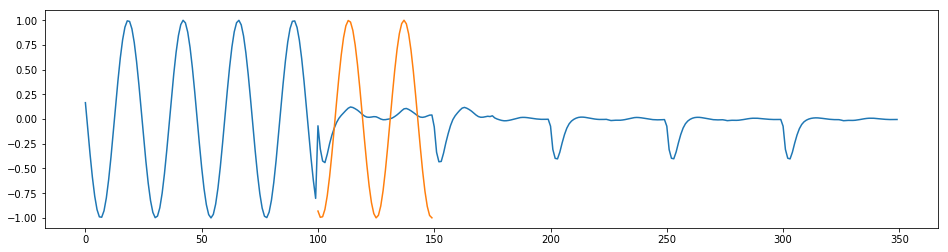

In [122]:
arrs, targets = next(gen)
arr, t = arrs[0], targets[0]
while len(arr) <= 3*SL:
    prediction = model.predict(arr[-SL:].reshape(1, SL, 1)).reshape(PL, 1)
    arr = np.concatenate((arr, prediction[:PL // 1]))

plt.figure(figsize=(16,4))
plt.plot(arr[:])
plt.plot(range(SL,SL+len(t)), t) 
#plt.plot([SL, SL], [-1, 1])
#plt.plot([SL+PL, SL+PL], [-1, 1])
plt.show()

In [ ]:
models = [
    (
        kl.InputLayer((20, 1)),
        kl.LSTM(1),
    ),
    (
        kl.InputLayer((20, 1)),
        kl.LSTM(2),
    )]

gen = data_generator(50, 20)

for model_layers in models:
    train_and_show_hist(keras.losses.mae, model_layers)


In [ ]:
for i in range(100):
    x, y = get_sequence_label_pair(L, 10*np.random.sample(100)-5)
    
    y = -1*y + 1
    
    #print(np.max(np.concatenate(((-x[1:] + x[:-1]), np.zeros(9))).reshape(2, 9), axis=0))
    print(x, y, model.predict(x.reshape(1, 10, 1)).flatten()[0])

In [ ]:
SL = 100
PL = SL // 2
model = build_model(
    kl.InputLayer((SL, 1)),
    kl.Flatten(),
    kl.Dense(SL), #kernel_constraint=keras.constraints.UnitNorm()),
    kl.Activation(kl.activations.tanh),
    kl.Dense(PL, kernel_constraint=keras.constraints.UnitNorm()),
    loss=keras.losses.cosine_proximity,
    optimizer='adam',
    verbose=1
)